In [1]:
dataset_name = "all_data_gift_certificates"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 128

In [2]:
import adclasses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/framework/ops.py:939: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


# Preprocess dataset

In [3]:
data = pd.read_csv(path, header=0)
data["timestamp"] = data["BeginTime"].values
del data["BeginTime"]
data["value"] = data["Count"].values
del data["Count"]
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)

data["timestamp"] = pd.to_datetime(data["timestamp"], 
                                   format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, 
                                                                   '1H', data))


ad = adclasses.UnivariateAnomalyDetection(dataframe=data, 
                                          timestep="1H", 
                                          dateformat="%Y-%m-%d %H:%M:%S", 
                                          name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2016-04-06 16:00:00",
                      "2016-07-25 19:00:00",
                      "2016-11-19 20:00:00"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2016-01-01 00:00:00
End date:  2016-12-31 23:00:00
Missing time stamps: 
 DatetimeIndex([], dtype='datetime64[ns]', freq='H')
Length:  8784
Time step size:  1H
Start Date:  2016-01-01 00:00:00
End Date:  2016-12-31 23:00:00
Date Format:  %Y-%m-%d %H:%M:%S
True outlier indices:  [2320, 4963, 7772]


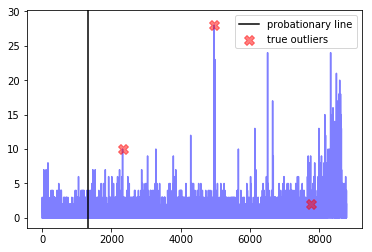

In [4]:
ad.plot_outliers([], true_outlier_indices)

# SARIMA: using autoarima

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 24); AIC=4685.250, BIC=4726.715, Fit time=4.291 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 24); AIC=3803.242, BIC=3813.609, Fit time=0.162 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 24); AIC=3670.361, BIC=3691.094, Fit time=3.674 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 24); AIC=3684.906, BIC=3705.638, Fit time=7.160 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 24); AIC=3714.963, BIC=3730.513, Fit time=0.277 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 24); AIC=3668.981, BIC=3694.896, Fit time=44.260 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 24); AIC=4233.173, BIC=4264.271, Fit time=31.422 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 0, 24); AIC=3689.690, BIC=3710.422, Fit time=27.457 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 0, 24); AIC=3653.701, BIC=3684.800, Fit time=46.151 seconds
Fit ARIMA: order=(2, 0, 

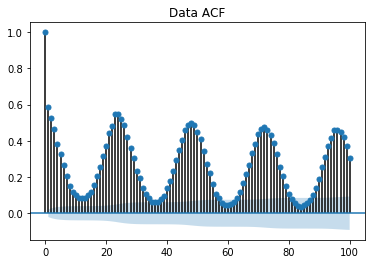

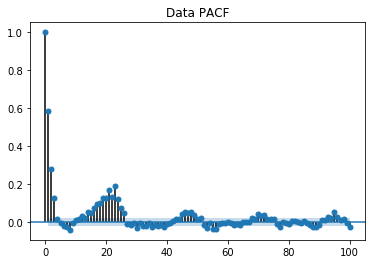

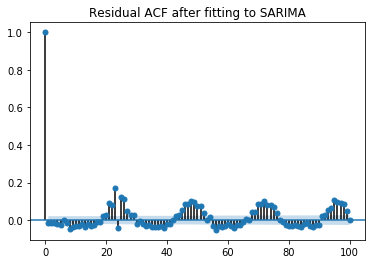

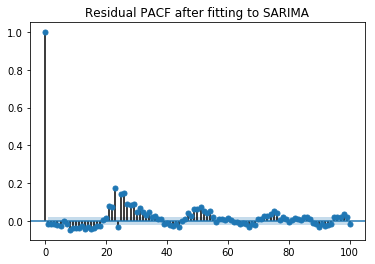

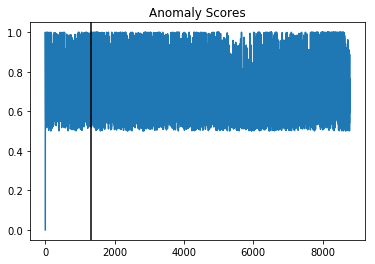

Time:  669.7656002044678
RMSE:  1.4414601668909401


['anomaly_scores/SARIMA_auto/all_data_gift_certificates']

In [5]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name
output_dict = ad.sarima(gaussian_window_size=gaussian_window_size,
                        autoarima=True, 
                        autoarima_season=True, 
                        s = 24,
                        plot_acf=True, 
                        maxiter=3, 
                        plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# Facebook Prophet

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


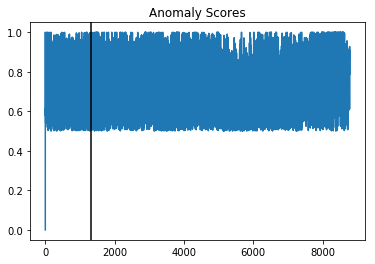

Time:  47.42439413070679
RMSE:  1.5567168342842936


['anomaly_scores/Prophet/all_data_gift_certificates']

In [6]:
save_path = "anomaly_scores/Prophet/" + dataset_name
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, periods=0, daily_seasonality=True, interval_width=.999, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# RNN

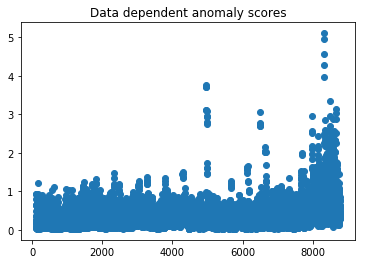

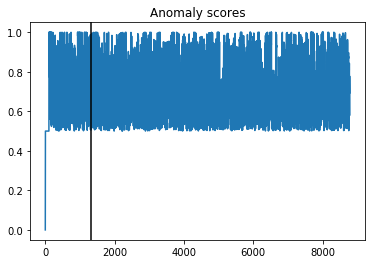

Time:  433.0786690711975


['anomaly_scores/RNN/all_data_gift_certificates']

In [4]:
save_path = "anomaly_scores/RNN/" + dataset_name
output_dict = ad.rnn(gaussian_window_size=gaussian_window_size, n_lag=100, n_seq=5, n_test=20, n_epochs=50,
                     n_batch=1, n_neurons=40, training_index=int(.15 * ad.get_length()), plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

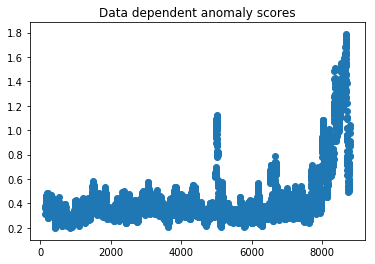

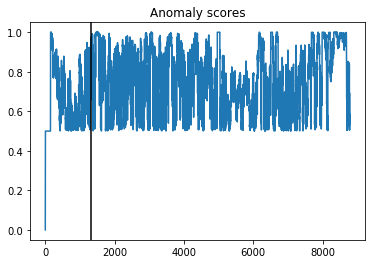

Time:  851.9786913394928


['anomaly_scores/RNN/all_data_gift_certificates']

In [7]:
save_path = "anomaly_scores/RNN/" + dataset_name
output_dict = ad.rnn(gaussian_window_size=gaussian_window_size, n_lag=100, n_seq=50, n_test=20, n_epochs=50,
                     n_batch=1, n_neurons=40, training_index=int(.15 * ad.get_length()), plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Twitter AD

R twitterad completed: True


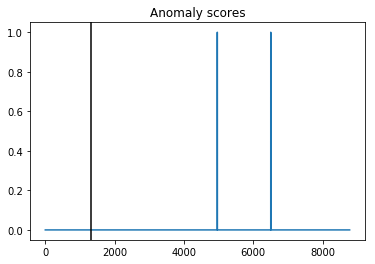

Time:  0.5680575370788574


['anomaly_scores/Twitter/all_data_gift_certificates']

In [8]:
save_path = "anomaly_scores/Twitter/" + dataset_name
output_dict = ad.twitterad(period=24, max_anoms=2/ad.get_length(), direction='both', alpha=.001, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HTM

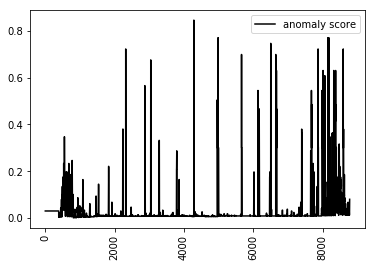

Time:  81.25


['anomaly_scores/HTM/all_data_gift_certificates']

In [9]:
htm_results_path = "htm_studio_results/" + "htm_results_" + dataset_name + "_value.csv"
htm_results = pd.read_csv(htm_results_path, header=0)

plt.plot(htm_results["raw_anomaly_score"], color="black", label="anomaly score")
plt.legend()
plt.xticks(rotation=90)
plt.show()

anomaly_scores = np.nan_to_num(htm_results["raw_anomaly_score"].values)

save_path = "anomaly_scores/HTM/" + dataset_name
print("Time: ", "81.25")
output_dict = {"Anomaly Scores": anomaly_scores, "Time": "81.25"}
joblib.dump(output_dict, save_path)

# Donut

Trainable Parameters              (58,150 in total)
---------------------------------------------------
donut/p_x_given_z/x_mean/bias    (120,)         120
donut/p_x_given_z/x_mean/kernel  (100, 120)  12,000
donut/p_x_given_z/x_std/bias     (120,)         120
donut/p_x_given_z/x_std/kernel   (100, 120)  12,000
donut/q_z_given_x/z_mean/bias    (5,)             5
donut/q_z_given_x/z_mean/kernel  (100, 5)       500
donut/q_z_given_x/z_std/bias     (5,)             5
donut/q_z_given_x/z_std/kernel   (100, 5)       500
sequential/_0/dense/bias         (100,)         100
sequential/_0/dense/kernel       (5, 100)       500
sequential/_1/dense/bias         (100,)         100
sequential/_1/dense/kernel       (100, 100)  10,000
sequential_1/_0/dense/bias       (100,)         100
sequential_1/_0/dense/kernel     (120, 100)  12,000
sequential_1/_1/dense/bias       (100,)         100
sequential_1/_1/dense/kernel     (100, 100)  10,000

[Epoch 10/256, Step 30, ETA 18.51s] Learning rate decreased to 

INFO:tensorflow:Restoring parameters from /tmp/tmpr679yg23/variables.dat-100


[Epoch 250/256, Step 750, ETA 0.1724s] Learning rate decreased to 7.525434581650002e-07


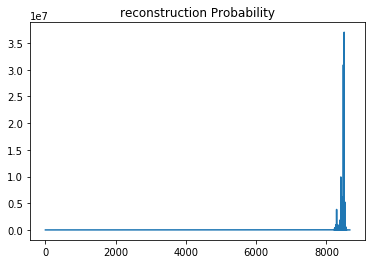

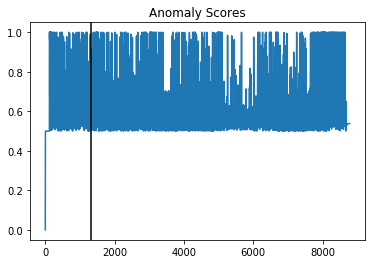

Time:  46.466721057891846


['anomaly_scores/Donut/all_data_gift_certificates']

In [10]:
save_path = "anomaly_scores/Donut/" + dataset_name
output_dict = ad.donut(gaussian_window_size=gaussian_window_size, plot_reconstruction_prob=True, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# STL Resid

R stlplus completed:  no missing True


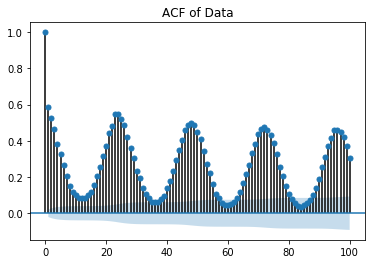

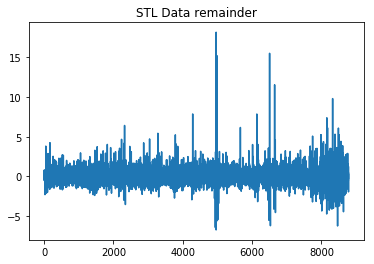

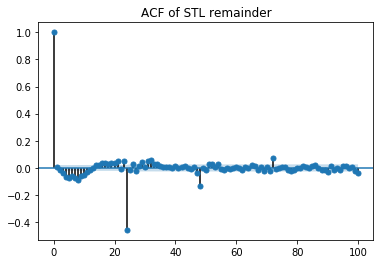

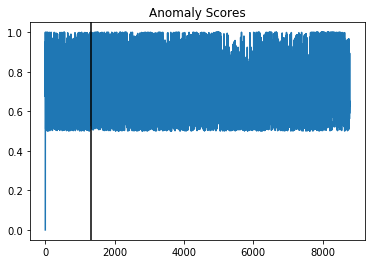

Time:  2.460674285888672


['anomaly_scores/stl/all_data_gift_certificates']

In [12]:
save_path = "anomaly_scores/stl/" + dataset_name
output_dict = ad.stl_resid(gaussian_window_size=gaussian_window_size, n_periods=24, swindow=7, outer=1, fill_option="linear", plot_resid=True, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# windowed gaussian

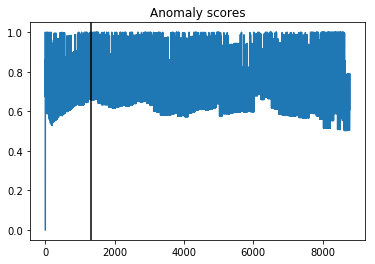

Time:  0.5518832206726074


['anomaly_scores/windowed_gaussian/all_data_gift_certificates']

In [13]:
save_path = "anomaly_scores/windowed_gaussian/" + dataset_name
output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HOTSAX

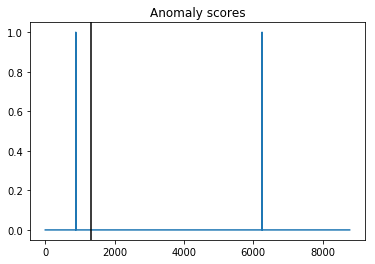

Time:  357.57916164398193


['anomaly_scores/hotsax/all_data_gift_certificates']

In [14]:
save_path = "anomaly_scores/hotsax/" + dataset_name
output_dict = ad.hotsax(win_size=50, num_discords=2,
               a_size=3, paa_size=3, z_threshold=0.01,
               plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

In [15]:
# SARIMA: using own params is noninvertible